# Tokyo Quantopian User Group Handson vol3


### Objectives

このノートでは、Quantopian Research を使ってどのようにペアトレーディングを構築していくかを学んで行きます。ノート修了時には、

+ ペアトレ構築方法
+ 銘柄ペアの探し方
+ 銘柄ペアの評価方法
+ 共和分とは何か
+ どのように共和分をテストするか
+ どのように取引シグナルを作るか
+ python library pandas の機能の一部
+ matplotlib の機能の一部

を理解していることを目標にします。

# ペアトレーディング

ペアトレーディング（以下ペアトレ）は、マーケットの暴騰や急落といった、急な変化に巻き込まれずに収益を上げていく方法として昔から使われてるストラテジーです。

ここに、似通った性格を持つ銘柄Xと銘柄Yの２つの銘柄があります。長い期間で見ると、どららの銘柄の価格もいつも大体同じような動きをしているものとしましょう。しかし短い期間で見てみると、時々違う動きをすることもあるとします。その場合、いずれ同じような動きに戻ってくると期待できるのであれば、差が開いた時に戻る方向へ取引すると儲かるのではないか、というのがペアトレの基本的な考え方です。

もう少し詳しく説明します。

銘柄XとYの価格がほぼ同じくらいであるとします。そうすると、長期的に見て**Xの価格とYの価格の差**はゼロあたりになるはずですが、ときには、この差が大きくなることがあります。つまり、これは何らかの理由で**Xが大きく値上りしているか、Yが大きく値下がりしている**ということです。

どちらかの銘柄の株価だけ先に動いたのであって、もう片方もいずれ追随してこの差がなくなると考えられるなら、まず**Xを売りYを買う**というポジションを取り、そして、価格差がなくなったときに反対売買（Xを買い戻しYを売る）を行えば利益を確定できます。

この仕組みは、XとYの関係だけに基づいていますから、株式市場全体が勢い良く上昇したり下降したりしても、原理的には関係ありません。株式市場が勢い良く下げて、Xの価格が下がるときにはYの価格も下がるでしょうから、これらの２つの動きは相殺されることになります。

もちろん２つの銘柄が未来永劫ずっと同じように動くという保証はどこにもありません。銘柄の関係性が薄れて全く異なる値動きをし始めることもあり得ます。そうなるとこのストラテジーは一切機能しません。


一般的に、株式の価格はランダムウォーク（酔っぱらいのオジサン歩き＝どっちに動くか分からない）に従っており、予測することは出来ないと考えられます。
しかし、<u>２つの銘柄の株価の動きの違いに着目</u>すると、一定の値の周りで変動するという現象がしばしば観測されます。これを**平均回帰性**といいます。


このノートでは、どうやってそのような銘柄の組み合わせを見つけるか、その組み合わせをどのようにシミュレーションしていくか、を学んで行きます。



## 平均回帰性

ペアトレでは２つの銘柄の価格の差がだいたい一定の範囲に収まっていることが必要です。
もし、片方の銘柄だけ値上がりし続けたり、値下がりし続ける場合には、価格の差はどんどん広がって、大きな損をすることもあるかもしれません。
いったん価格の差が開いても、元に戻る性質のことを、**平均回帰性**と言います。

例を出します。金採掘会社関連銘柄のGDXとABXについて、2010/1/3から2017/12/31までの動きを見てみます。


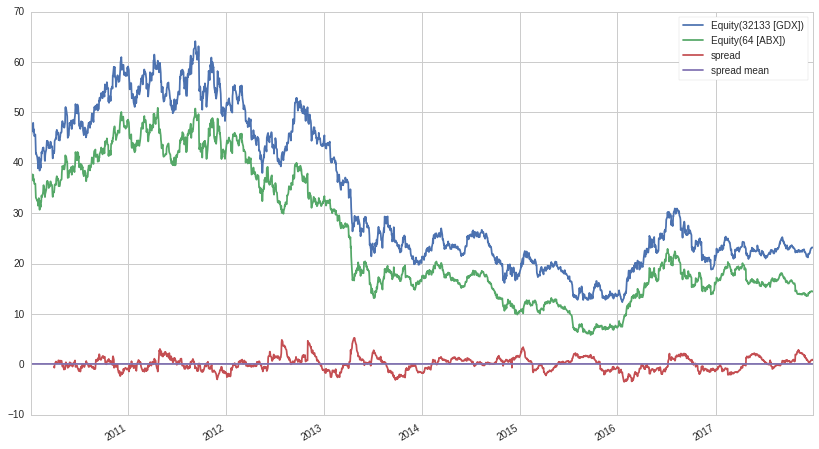

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

def draw(x, y, term, start_date, end_date):
    df = get_pricing([x, y], fields='price', start_date=start_date, end_date=end_date)
    return draw_df(df, x, y, term)
    
def draw_df(df, x, y, term):
    beta = df[x].rolling(window=term).mean()/df[y].rolling(window=term).mean()
    df['spread'] = df[x] - beta*df[y]
    df['spread mean'] = df["spread"].mean()
    df.plot()
    return df
    
GDX = symbols('GDX')
ABX = symbols('ABX')
term = 60
start_date='2010-01-03'
end_date='2017-12-31'
df_GDX_ABX = draw(GDX, ABX, term, start_date, end_date)

ここでは、XをGDX、YをABXとしています。

**beta** は、過去60日間のXとYの価格の比を示しています。Yの価格にbetaを掛ければ、Xと直接比較出来るようになります。その差を**df['spread']**に入れています。

赤線spreadがゼロの線を取り巻くように上下に動いています。とくに、上に大きくスパイクすると急速にゼロに戻っているように見えますね。こういう場合に収益機会がありそうです。


## よりよいペアを見つけよう

こういうペアをたくさん見つける事ができたら、人生幸せになれるような気がしてきました。しかし、本当に儲かる可能性のある銘柄のペアなのかそうでないのかを、このように目視で判断して行くほど人生は長くありません。

また目視判断では、他のペアと比較してどっちがより良いペアなのかといった相対的な判断が非常に難しいです。

そこでもう少し統計的にチェックする方法を見ていきたいと思います。

まずは正規分布に従う乱数を使って仮想の株価を２つ作ってみます。**乱数で作った株価ですから、お互いなんの関係もないので平均回帰性が見えるはずはない事をプロットして確認してみましょう**。



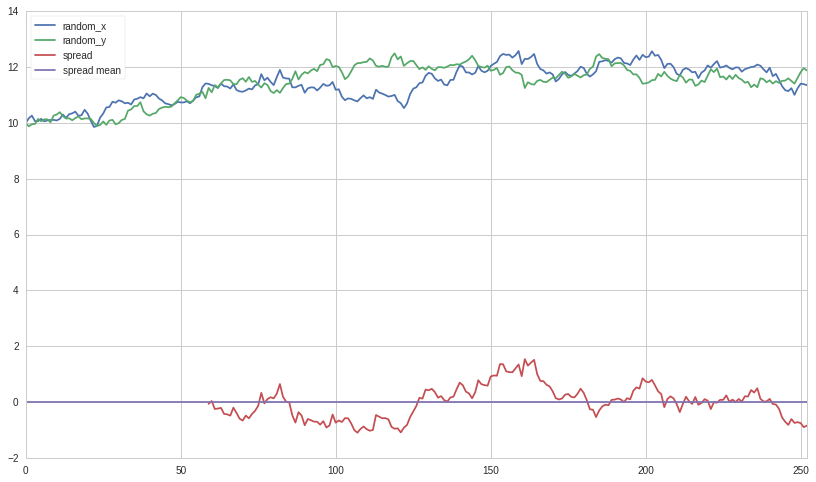

In [2]:
def make_price_movement(init_price, average_return, volatility, num_units):
    returns = np.random.normal(average_return/num_units, volatility/math.sqrt(num_units), num_units)
    price_list = [init_price]
    for x in returns:
        price_list.append(price_list[-1]*(1.0+x))
    return price_list


INIT_PRICE = 10.0
AVERAGE_RETURN = 0.05
VOLATILITY = 0.2
NUM_UNITS = 252 
np.random.seed(10)
random_x = make_price_movement(INIT_PRICE, AVERAGE_RETURN, VOLATILITY, NUM_UNITS)
random_y = make_price_movement(INIT_PRICE, AVERAGE_RETURN, VOLATILITY, NUM_UNITS)
df = pd.DataFrame({'random_x':random_x, 'random_y':random_y})
df_randoms = draw_df(df, 'random_x', 'random_y', term)


ん？なにかおかしいですね。random_xとrandom_yはそれほど同じような値動きには見えませんが、そのスプレッドは平均回帰性をもっているように見えなくもありませんね。

これは目視確認だと騙されてしまうかもしれません．




## 共和分

金鉱関連株同士のGDXとABXのように、実際に同じような性格をもって動くペアと、たまたま同じように動いて見えることがあるだけの、乱数で作ったペアの良し悪しを見分け、騙されないようにするには、どうしたら良いでしょうか。

そのための分析方法として、**共和分**というものがあります。２つの価格の動きに共和分が認められれば、平均回帰性があるということが知られています。




### 共和分をテストする

python の統計モデルライブラリ [StatsModels](http://www.statsmodels.org/dev/index.html) の `statsmodels.tsa.stattools`の中にある [coint](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.coint.html) という関数を使って、２つの時系列が共和分しているかどうか確認します。

`coint(X,Y)` は３つの値 coint_t, p_value, crit_value を返します。

そのなかの、p_value (p値)が小さければ小さいほど、2つの価格が共和分性を持つことを示します。
一般的に、p値が0.05を下回っていれば、共和分性があると言って良いと言われています。

では，GDXとABXのp値と，random_x/random_yのp値を見てみましょう．


In [3]:
from statsmodels.tsa.stattools import coint
# GDXとABXのケース
coint_t, p_value, crit_value = coint(df_GDX_ABX[GDX], df_GDX_ABX[ABX])
print 'GDXとADX:', p_value

# 乱数のケース
coint_t, p_value, crit_value = coint(random_x, random_y)
print '２つの乱数:', p_value

GDXとADX: 0.0031994375631
２つの乱数: 0.207538565498


大きな違いが出ましたね。

### 関連のありそうな銘柄とは

それでは、共和分する銘柄ペアを探すには、どうしたら良いでしょうか。

<u>相場にある全銘柄でペアを作り、片っ端からその差の共和分を取得し、良いペアを探しせばいいのでは！？</u>とやりたいところですがさすがに大変です。

一般的に同じような値動きをする銘柄は、同じ業種や同じ商品のサプライヤー等、**経済的に関連がありそうな銘柄**があげられます。（例：資生堂と花王（化粧品）や，村田製作所とアルプス電気（iphoneサプライヤ））。

そこで関連がありそうな銘柄を複数集めて、そこで総当りさせるコードを書いてみましょう。

Quantopianではアメリカ株だけ取得可能ですので、ここでは金鉱株を集めて共和分を見ていきたいと思います。


In [4]:
import itertools

def find_cointegrated_pairs(pair_list, start_date, end_date):
    prices = get_pricing(pair_list, start_date=start_date, end_date=end_date, fields="price", frequency="daily")
    prices.columns = map(lambda x: x.symbol, prices.columns)
    pairs = list(itertools.combinations(pair_list, 2))
    p_value_list = list()
    for x, y in pairs:
        _, p_value, _ = coint(prices[x], prices[y])
        p_value_list.append([x, y, p_value])
    return sorted(p_value_list, key=lambda x: x[2])  

start_date = "2011-01-01"
end_date = "2018-01-01"
pairlist = ['AEM', 'GG', 'AUY', 'KGC', 'EGO', 'ABX', 'NEM', 'GDX']
find_cointegrated_pairs(pairlist, start_date, end_date)

[['GG', 'EGO', 0.00035199514497213929],
 ['ABX', 'GDX', 0.018585257407773038],
 ['KGC', 'GDX', 0.020873311829083661],
 ['KGC', 'ABX', 0.042178503802169406],
 ['GG', 'KGC', 0.1561674142083837],
 ['KGC', 'EGO', 0.27524902749935387],
 ['KGC', 'NEM', 0.28297264434287039],
 ['AEM', 'AUY', 0.30136064920103023],
 ['AEM', 'NEM', 0.36875136739646974],
 ['AUY', 'EGO', 0.39318404550431985],
 ['AEM', 'GG', 0.45197999020611512],
 ['GG', 'ABX', 0.45576828890018117],
 ['AEM', 'ABX', 0.51032012148333672],
 ['GG', 'AUY', 0.51683616914143549],
 ['AEM', 'EGO', 0.52062380326687097],
 ['AEM', 'KGC', 0.54871019014537048],
 ['AEM', 'GDX', 0.5605752018766621],
 ['AUY', 'KGC', 0.56781694548515926],
 ['EGO', 'ABX', 0.58153095001149269],
 ['AUY', 'ABX', 0.70270969510323733],
 ['GG', 'GDX', 0.72056130271817642],
 ['EGO', 'GDX', 0.75826340161766703],
 ['AUY', 'GDX', 0.75978304530907104],
 ['ABX', 'NEM', 0.77884500009390134],
 ['NEM', 'GDX', 0.81652270342653921],
 ['EGO', 'NEM', 0.92652719284101681],
 ['AUY', 'NEM'

p値が0.05を下回っている良さそうな組み合わせがありますね。さきほどのGDXとABXよりも、[ゴールドコープ【GG】](https://stocks.finance.yahoo.co.jp/us/detail/GG)と[エルドラド・ゴールド【EGO】](https://stocks.finance.yahoo.co.jp/us/detail/EGO)の方が良い値です。こちらに注目してみることにします。

なお、違う期間を取って組み合わせを評価すれば、違った結果が出てきますので、この組み合わせが一番いいとは限らないことに注意してください。

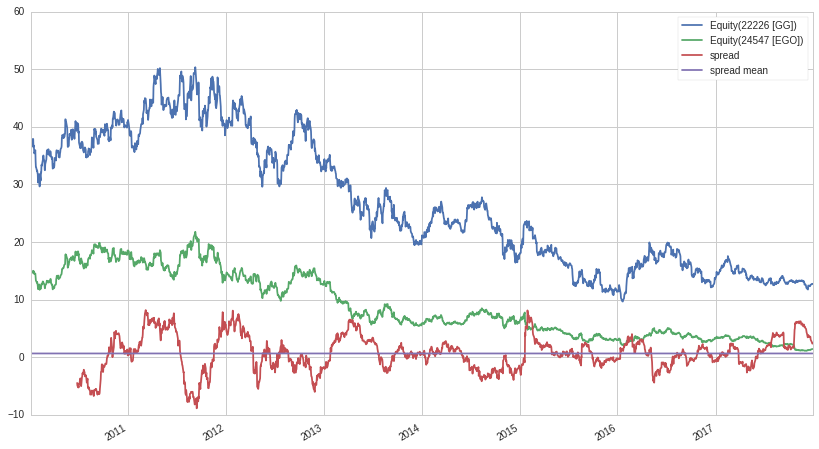

In [5]:
GG = symbols('GG')
EGO = symbols('EGO')
term = 120
start_date='2010-01-03'
end_date='2017-12-31'
df_GG_EGO = draw(GG, EGO, term, start_date, end_date)

良さそうな感じですね。では、この2つの銘柄を2011年から2017年末まで取得して、実際のシュミュレーションを行ってみましょう。


赤線は、移動平均からの価格差ですが、これが５以上なら、GGを売りEGOを買い、−５以下であればEGOを売りGGを買うというストラテジーを組んでみましょう。

実際に取引するときには、取引の費用や、株の流動性なども問題になりますが、そういう点については、QuantopianのAlgorithmの機能が役に立ちます。ここでは、Algorithmで作業をする前に、ざっくりとした計算でストラテジーの様子を把握します。

In [6]:
## ストラテジーをシュミュレーション

x = symbols('GG')
y = symbols('EGO')
term = 60
start_date='2010-01-03'
end_date='2017-12-31'
threshold = 5

# 価格取得
df = get_pricing([x, y], fields='price', start_date=start_date, end_date=end_date, frequency='daily')

# スプレッド計算
beta = df[x].rolling(window=term).mean()/df[y].rolling(window=term).mean()
df['spread'] = df[x] - beta*df[y]

# 一定の値を超えたかどうかの判定
df['above_threshold'] = df["spread"] > threshold
df['below_threshold'] = df["spread"] < -threshold

# ポジション保有判定
df['position'] = np.nan
df.loc[df['above_threshold'], 'position'] = -1
df.loc[df['below_threshold'], 'position'] = 1
df['position'] = df['position'].fillna(method='ffill')


# 毎日資金の補充をする前提でざっくり利益の計算をする
df["x_return"] = df[x].pct_change().shift(-1)
df["y_return"] = df[y].pct_change().shift(-1)

df['pair_return'] = (df['x_return']-df['y_return']) * df['position']
df['amount'] = (df['pair_return']+1.0).cumprod()

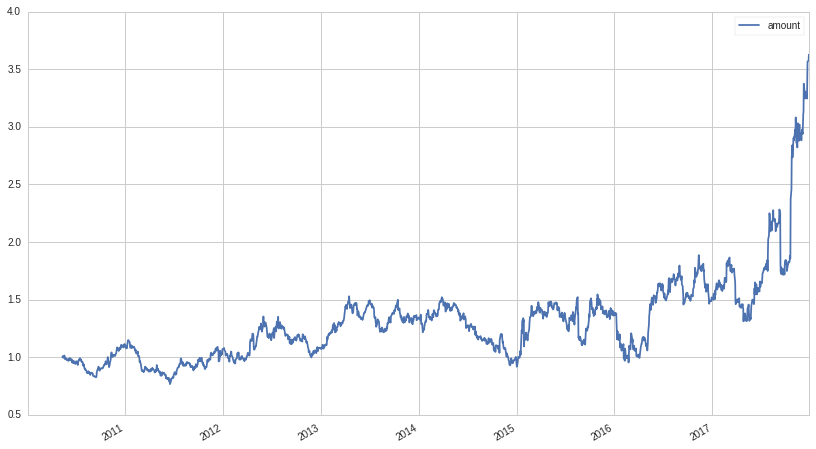

In [7]:
df[['amount']].plot()


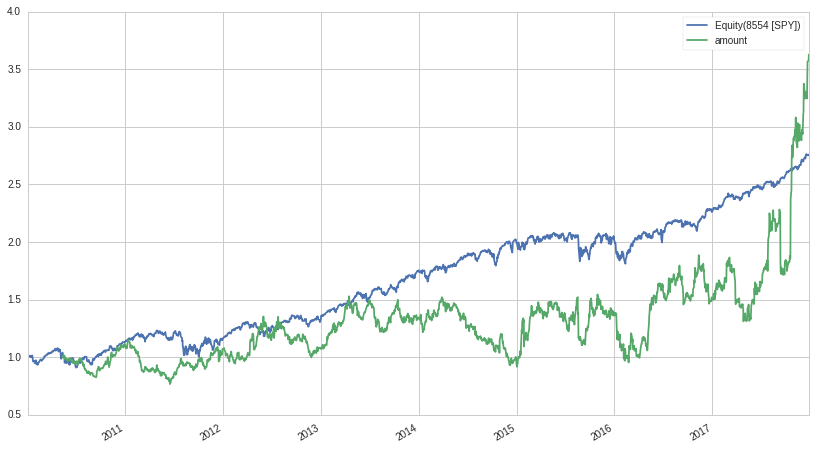

In [8]:
spy = get_pricing("SPY", start_date=df.index[0], end_date=df.index[-1], fields='price', frequency='daily')    
(spy.pct_change()+1).cumprod().plot(legend=True)
df['amount'].plot(legend=True)

![](https://2.bp.blogspot.com/-Bhz3_9xEJik/Wge7_Na6SoI/AAAAAAABIEs/chEBfuSE-Wc4LX8yyHaz_5-M2lxvC5eFgCLcBGAs/s180-c/kuji_hazure_woman.png)

うーーーーん・・・これではSPYを黙って持っている方が全然ましということになります。

なかなか人生うまく行かないわけですが、せっかくですので，みんなで手分けして良いストラテジーを探してみましょう。

思いついた改良ポイントを紹介しますので、これをヒントに改良してみてもらってもよいですし、何かご自身で思いつくモノがあればやってみて下さい。

(๑•̀ㅂ•́)و✧

### 改良（？）ヒント

+ 違うペアを探す
+ 違う業種を探す [S&P 500 Map](https://finviz.com/map.ashx?t=sec)
+ 複数ペアの組み合わせ
+ term をもっと短く/長く
+ 20日移動平均+ボリンジャーバンドの組み合わせ



---

## appendix1 

### p値が一番悪かったペア，GG/ NEMでやって見る

まず値動きと spread を見てみましょう．coint で計算すると良くない結果でしたが，spread の動きを見ると平均回帰性があるように見えます．


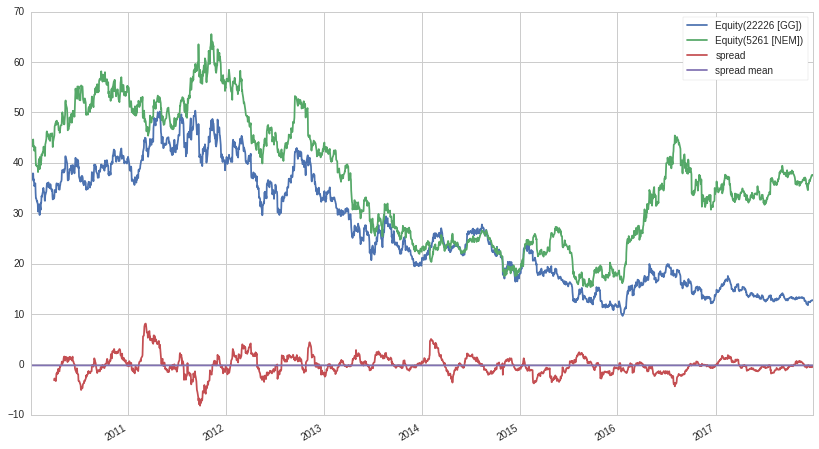

In [10]:
GG = symbols('GG')
NEM = symbols('NEM')
term = 60
start_date='2010-01-03'
end_date='2017-12-31'
df_GG_NEM = draw(GG, NEM, term, start_date, end_date)

**しかし**、上記のストラテジーをシュミュレーションをGGとNEMに変更して実行してみて下さい。GG/EGOと大差ない結果が返ってくると思います。ツライですね。


---

## appendix 2

### finpy もくもく会その１１でやってみたこと

先日、finpy もくもく会＃11でみなさんのお知恵をお借りして色々とペアトレを考えてみました。

+ USOとGLD，EWAとEWC（以下XとYとして読み替えて下さい）
+ X/Yの２０日移動平均と２０日標準偏差で，ZSCOREを取得
+ ①ZSCOREが２より大きい場合、X売りY買い、ZSCOREが-２より小さい場合、X買いY売り。
+ ②前日のZSCOREが今日のZSCOREより小さくて、且つZSCOREが２より大きい場合、X売りY買い。前日のZSCOREが今日のZSCOREより大きく、且つ且つZSCOREが-２より小さい場合、X買いY売り。
+ ①②両方に対して
    + どちらの条件も満たさなかった場合は、ポジションクローズする
    + どちらの条件も満たさなかった場合は、前日のポジションを維持する
 　




In [11]:
x = symbols("EWA")
y = symbols("EWC")
term = 20
df = get_pricing([x,y], fields='price', frequency='daily', start_date=start_date, end_date=end_date)


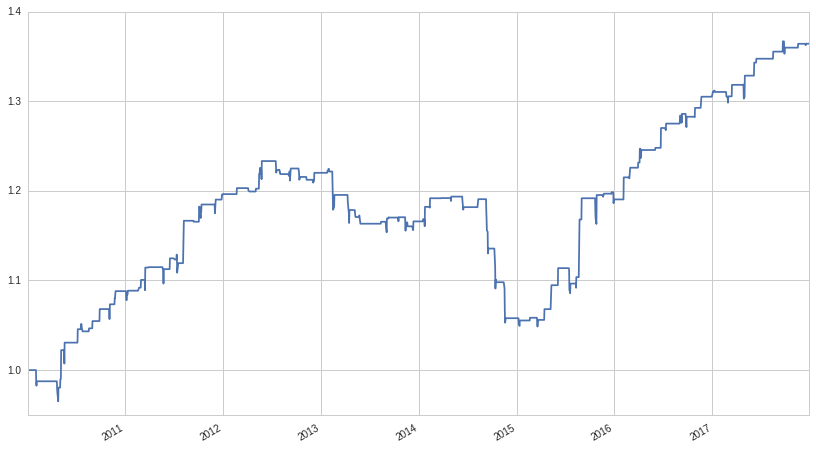

In [12]:
df['ratio'] = df[x] / df[y]
df['mean'] = df['ratio'].rolling(window=term).mean()
df['std'] =  df['ratio'].rolling(window=term).std()
df['zscore'] = (df['ratio'] - df['mean']) / df['std']


zscore_threshold = 2

#①
df["above_threshold"] = df['zscore'] > zscore_threshold
df["below_threshold"] = df['zscore'] < -zscore_threshold

# #②
# df["above_threshold"] = (df['zscore'] > zscore_threshold) & (df['zscore'] < df['zscore'].shift(1))
# df["above_threshold"] = (df['zscore'] < -zscore_threshold) & (df['zscore'] > df['zscore'].shift(1))

# どちらの条件も満たさなかった場合は，ポジションクローズする
df['position'] = 0
df.loc[df['above_threshold'], 'position'] = -1
df.loc[df['below_threshold'], 'position'] = 1

df["x_return"] = df[x].pct_change().shift(-1)
df["y_return"] = df[y].pct_change().shift(-1)

df['pair_return'] = (df['x_return']-df['y_return']) * df['position']

df['amount'] = (df['pair_return']+1.0).cumprod()
df['amount'].plot()

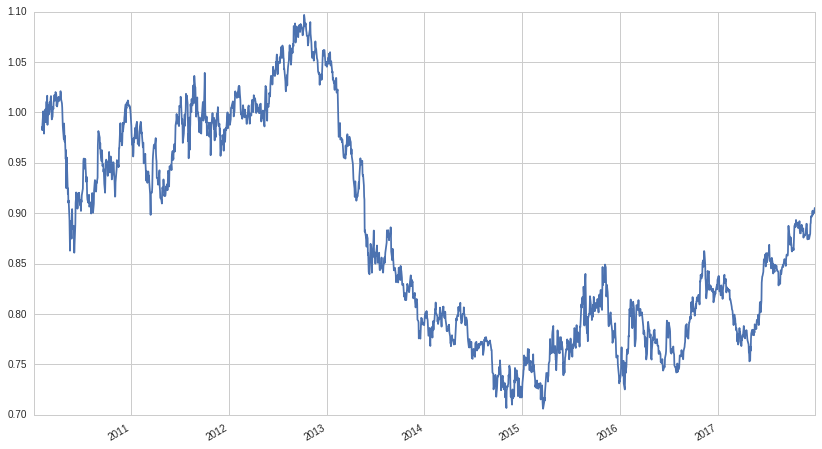

In [13]:
df['ratio'] = df[x] / df[y]
df['mean'] = df['ratio'].rolling(window=term).mean()
df['std'] =  df['ratio'].rolling(window=term).std()
df['zscore'] = (df['ratio'] - df['mean']) / df['std']


zscore_threshold = 2

#①
df["above_threshold"] = df['zscore'] > zscore_threshold
df["below_threshold"] = df['zscore'] < -zscore_threshold

# #②
# df["above_threshold"] = (df['zscore'] > zscore_threshold) & (df['zscore'] < df['zscore'].shift(1))
# df["above_threshold"] = (df['zscore'] < -zscore_threshold) & (df['zscore'] > df['zscore'].shift(1))

# どちらの条件も満たさなかった場合は，前日のポジションを維持する 
df['position'] = np.nan
df.loc[df['above_threshold'], 'position'] = -1
df.loc[df['below_threshold'], 'position'] = 1
df['position'] = df['position'].fillna(method='ffill')

df["x_return"] = df[x].pct_change().shift(-1)
df["y_return"] = df[y].pct_change().shift(-1)

df['pair_return'] = (df['x_return']-df['y_return']) * df['position']

df['amount'] = (df['pair_return']+1.0).cumprod()
df['amount'].plot()

## アルゴリズムでシミュレーション

さて上手くいったら（いかなくても）アルゴリズムでシミュレーションしてみましょう。

テンプレートを作りましたのでアルゴリズムで使ってみて下さい。


```python

"""


This is a template algorithm on Quantopian for TQUG pair trades 
ハンズオンで勉強した条件でアルゴリズムを作ってみましょう
+ GGとEGO
+ 60日移動平均
+ spreadは移動平均の引き算
+ threshold は3
+ 一旦thresholdにヒットしたら，反対にヒットするまでホールド
+ 確認はクローズ時

"""
import quantopian.algorithm as algo

def initialize(context):
    context.x = sid(22226) #GG
    context.y = sid(24547) #EGO
    context.term = 120
    context.threshold = 5
    
    # 取引終了時にリバランス
    algo.schedule_function(
        rebalance,
        algo.date_rules.every_day(),
        algo.time_rules.market_close(),
    )
    algo.schedule_function(
        record_vars,
        algo.date_rules.every_day(),
        algo.time_rules.market_close(),
    )

    
def rebalance(context, data):
    pricex = data.history(context.x, fields="price", bar_count=context.term, frequency="1d")
    pricey = data.history(context.y, fields="price", bar_count=context.term, frequency="1d")
    pricex_mean = pricex.mean() 
    pricey_mean = pricey.mean() 
    
    beta = pricex_mean / pricey_mean
    context.spread = pricex[-1] - pricey[-1] * beta 
    
    if context.spread > context.threshold:
        if data.can_trade(context.x) and data.can_trade(context.y):
            order_percent(context.x, -0.5)
            order_percent(context.y, 0.5)
    elif context.spread < -context.threshold:
        if data.can_trade(context.x) and data.can_trade(context.y):
            order_percent(context.x, 0.5)
            order_percent(context.y, -0.5)
            
    else:
        pass 
    
def record_vars(context, data):
    record(spread=context.spread)


def handle_data(context, data):
    pass
    ```


### references 

+ [How to Build a Pairs Trading Strategy on Quantopian?](https://www.quantopian.com/posts/how-to-build-a-pairs-trading-strategy-on-quantopian)
+ [CiNii 論文 -  共和分性に基づく最適ペアトレード](https://ci.nii.ac.jp/naid/120006224721/)